In [3]:
%pip install torchvision
%pip install torch --index-url https://download.pytorch.org/whl/cu118
%pip install tqdm

Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://download.pytorch.org/whl/cu118
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


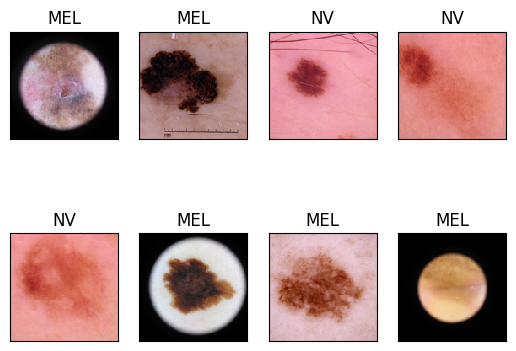

In [4]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision

train_folder = ImageFolder('~/aml/DAT341-Applied-Machine-Learning/PA5/Data/a5_data_new/train', transform=torchvision.transforms.ToTensor())
train_loader = DataLoader(train_folder, batch_size=8, shuffle=True)

Xexamples, Yexamples = next(iter(train_loader))

for i in range(8):
    plt.subplot(2,4,i+1)  
    img = Xexamples[i].numpy().transpose(1, 2, 0)    
    plt.imshow(img, interpolation='none')
    plt.title('NV' if Yexamples[i] else 'MEL')
    plt.xticks([])
    plt.yticks([])


In [5]:
import torch
import torchvision
val_folder = ImageFolder('~/aml/DAT341-Applied-Machine-Learning/PA5/Data/a5_data_new/val', transform=torchvision.transforms.ToTensor())
val_loader = DataLoader(val_folder, batch_size=8, shuffle=True)

Got code from canvas to train our classfier. 

In [52]:
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import accuracy_score
    
def train_classifier(model, train_data, val_data, hyperparams):

    # Deals with model updates. Adam is more effective than SGD.
    optimizer = torch.optim.Adam(model.parameters(), lr=hyperparams['lr'])    
    
    # Binary Cross-entropy loss because we have 2 classes.
    # Note that the softmax is "baked into" this loss, so we should not
    # use a softmax at the end.
    loss_func = torch.nn.BCELoss()
      
    # Some statistics.
    acc_history = []
    min_val_loss= float('inf')
    for epoch in range(hyperparams['max_epochs']):

        # Set the model in training mode, enabling dropout if we use that.
        model.train()
        
        loss_sum = 0

        # For each batch
        for Xbatch, Ybatch in tqdm(train_data):
            # Apply the model. We don't know at this point what the model is.
            # The output should be of the shape (batch_size, 10).
            outputs = model(Xbatch)
     
            # Apply the cross-entropy loss.
            loss = loss_func(outputs.squeeze(), Ybatch.float())

            # Update the model.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_sum += loss.item()

        # Set the model in evaluation mode. Disables dropout if present.
        model.eval()
        with torch.no_grad():
            # Compute the accuracy on the validation data.
            val_acc, val_loss = predict_and_evaluate(model, val_data)
                
        mean_loss = loss_sum / len(train_data)
        
        acc_history.append(val_acc)
        
        print(f'Epoch {epoch+1}: train loss = {mean_loss:.4f}, val acc = {val_acc:.4f}, val loss = {val_loss:.4f}')

        if val_loss < min_val_loss:
            min_val_loss = val_loss
        elif val_loss > min_val_loss:
            break

    return acc_history
        
    
# A utility function to compute accuracies during training.
def predict_and_evaluate(model, data):
    loss_func = torch.nn.BCELoss()
    loss_sum = 0
    all_gold = []
    all_pred = []

    for Xbatch, Ybatch in data:
        outputs = model(Xbatch)
        loss = loss_func(outputs.squeeze(), Ybatch.float())
        loss_sum += loss.item()

        predictions = torch.round(outputs)

        all_gold.extend(Ybatch.numpy())
        all_pred.extend(predictions.numpy())
    mean_loss = loss_sum / len(data)
    return accuracy_score(all_gold, all_pred), mean_loss

In [53]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, ks):
        super().__init__()
        # 3 channel rgb
        self.conv1 = nn.Conv2d(3, 32, kernel_size=ks)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=ks)
        self.conv3 = nn.Conv2d(64,128, kernel_size=ks)
        self.fc = nn.Linear(self.flatten_size(ks), 512)
        self.output = nn.Linear(512, 1)

    def flatten_size(self, ks):
        if ks == 3:
            return 128*14*14
        elif ks == 5:
            return 128*12*12
        else: 
            return 0 
           
    def forward(self, X):
        c1 = self.conv1(X)
        fm1 = F.max_pool2d(F.relu(c1), 2)

        c2 = self.conv2(fm1)
        fm2 = F.max_pool2d(F.relu(c2), 2)

        c3 = self.conv3(fm2)
        fm3 = F.max_pool2d(F.relu(c3), 2)
        # This was used to calculate flattened size
        #print(fm3.shape)
        fl = torch.flatten(fm3, start_dim=1)

        h1 = F.relu(self.fc(fl))
        out = torch.sigmoid(self.output(h1))
        return out

In [51]:
torch.random.manual_seed(2)
cnn3 = CNN(3)
cnn5 = CNN(5)
#print('ks=3, lr=1e-3')
#hist3_lrm3 = train_classifier(cnn3, train_loader, val_loader,{'lr': 1e-3, 'max_epochs': 1})
print('ks=3, lr=1e-4')
hist3_lrm2 = train_classifier(cnn3, train_loader, val_loader,{'lr': 1e-4, 'max_epochs': 20})
print('ks=3, lr=1e-5')
hist3_lrm2 = train_classifier(cnn3, train_loader, val_loader,{'lr': 1e-5, 'max_epochs': 20})

#print('ks=5, lr=1e-3')
#hist5_lrm3 = train_classifier(cnn5, train_loader, val_loader,{'lr': 1e-3, 'max_epochs': 1})
#print('ks=5, lr=1e-2')
#hist5_lrm2 = train_classifier(cnn5, train_loader, val_loader,{'lr': 1e-2, 'max_epochs': 1})

ks=3, lr=1e-4


100%|█████████████████████████████████████████████████████████████████████████████████| 804/804 [01:43<00:00,  7.79it/s]


Epoch 1: loss = 0.5004, val acc = 0.7843


100%|█████████████████████████████████████████████████████████████████████████████████| 804/804 [01:53<00:00,  7.05it/s]


Epoch 2: loss = 0.4183, val acc = 0.7668
ks=3, lr=1e-5


100%|█████████████████████████████████████████████████████████████████████████████████| 804/804 [01:43<00:00,  7.78it/s]


Epoch 1: loss = 0.3780, val acc = 0.8027


100%|█████████████████████████████████████████████████████████████████████████████████| 804/804 [01:49<00:00,  7.36it/s]


Epoch 2: loss = 0.3660, val acc = 0.8027


100%|█████████████████████████████████████████████████████████████████████████████████| 804/804 [01:42<00:00,  7.85it/s]


Epoch 3: loss = 0.3611, val acc = 0.8187


100%|█████████████████████████████████████████████████████████████████████████████████| 804/804 [01:40<00:00,  8.02it/s]


Epoch 4: loss = 0.3555, val acc = 0.8091


Think there's something wrong with the 1e-2's as they show 0.5000

In [32]:
class BatchNormalizationCNN(nn.Module):
    def __init__(self, ks):
        super().__init__()
        # 3 channel rgb
        self.conv1 = nn.Conv2d(3, 32, kernel_size=ks)
        self.batchn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=ks)
        self.batchn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64,128, kernel_size=ks)
        self.batchn3 = nn.BatchNorm2d(128)
        self.fc = nn.Linear(self.flatten_size(ks), 512)
        self.batchn4 = nn.BatchNorm1d(512)
        self.output = nn.Linear(512, 1)

    def flatten_size(self, ks):
        if ks == 3:
            return 128*14*14
        elif ks == 5:
            return 128*12*12
        else: 
            return 0 
           
    def forward(self, X):
        c1 = self.conv1(X)
        bn1 = self.batchn1(c1)
        fm1 = F.max_pool2d(F.relu(bn1), 2)

        c2 = self.conv2(fm1)
        bn2 = self.batchn2(c2)
        fm2 = F.max_pool2d(F.relu(bn2), 2)

        c3 = self.conv3(fm2)
        bn3 = self.batchn3(c3)
        fm3 = F.max_pool2d(F.relu(bn3), 2)
        
        # This was used to calculate flattened size
        #print(fm3.shape)
        fl = torch.flatten(fm3, start_dim=1)

        h1 = F.relu(self.batchn4(self.fc(fl)))
        out = torch.sigmoid(self.output(h1))
        return out

In [33]:
cnnBN = BatchNormalizationCNN(3)
history = train_classifier(cnnBN,train_loader,val_loader,{'lr':1e-3, 'max_epochs':3 })

100%|█████████████████████████████████████████████████████████████████████████████████| 804/804 [01:57<00:00,  6.83it/s]


Epoch 1: loss = 0.5004, val acc = 0.7883
